# Imports 

In [1]:
from pybaseball import spraychart
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib.ticker import PercentFormatter

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
stanton = pd.read_csv('../data/giancarlo-stanton.csv')
stanton.drop(columns = ['Unnamed: 0'], inplace = True)

# Font Dictionary
font_title = {
    'size': 12,
    'weight': 'bold',
    'verticalalignment': 'center_baseline',
    'horizontalalignment': 'center'
}

pd.set_option('max_columns', None)
print(stanton.shape)
stanton.head(2)

(2426, 89)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,fielder_2,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,is_strike,pitch_count,plate_-x,pfx_-x,swing_miss
0,FF,2021-10-03,95.9,-1.78,6.35,"Stanton, Giancarlo",519317,608379,out,hit_into_play,7.0,Giancarlo Stanton flies out to right fielder R...,R,R,R,NYY,TB,X,9.0,fly_ball,2,2,2021,-0.89,14.16,-0.69,2.20,NaN,NaN,650402.0,2,4,Bot,181.19,120.39,572287,4.936664,-139.502697,-8.110468,-12.687337,30.485721,-15.110574,3.66,1.68,278.0,85.4,28.0,96.8,2024.0,6.8,632239,608379,572287,596847,664040,621563,677551,640457,595281,668227,53.73,0.071,0.086,0.0,1.0,0.0,0.0,3.0,30,6,4-Seam Fastball,0,0,0,0,0,0,0,0,Standard,Standard,210.0,-0.028,-0.192,1,2-2,0.69,10.68,0
1,FF,2021-10-03,96.1,-1.72,6.31,"Stanton, Giancarlo",519317,608379,NaN,ball,11.0,Giancarlo Stanton flies out to right fielder R...,R,R,R,NYY,TB,B,NaN,NaN,1,2,2021,-0.61,18.12,-0.51,4.88,NaN,NaN,650402.0,2,4,Bot,NaN,NaN,572287,4.630125,-139.866434,-1.607320,-9.063359,31.957645,-12.240695,3.80,1.90,NaN,NaN,NaN,96.8,2238.0,6.7,632239,608379,572287,596847,664040,621563,677551,640457,595281,668227,53.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,5,4-Seam Fastball,0,0,0,0,0,0,0,0,Standard,Standard,209.0,0.000,0.037,0,1-2,0.51,7.32,0


In [3]:
zero_zero = stanton.loc[(stanton['pitch_count'] == '0-0')]
zero_zero.description.value_counts()

ball               252
called_strike      217
foul                41
hit_into_play       35
swinging_strike     34
Name: description, dtype: int64

In [4]:
# Feature engineer first_pitch_take column by taking count and if pitch was called a strike
stanton['first_pitch_take'] = [1 if x == '0-0' and y == 'called_strike' else 0 for (x, y) 
                                in zip(stanton['pitch_count'], 
                                       stanton['description'])]

# feature engineer first_pitch_swing column by taking count, if launch speed is > 0 or if swing_miss = 1
stanton['first_pitch_swing'] = [1 if x == '0-0' and (y > 0 or z > 0) else 0 for (x, y, z) 
                                 in zip(stanton['pitch_count'], 
                                        stanton['launch_speed'],
                                        stanton['swing_miss'])]

In [5]:
stanton.groupby(['bb_type']).mean()

,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,hit_location,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,hc_x,hc_y,fielder_2,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,spin_axis,delta_home_win_exp,delta_run_exp,is_strike,plate_-x,pfx_-x,swing_miss,first_pitch_take,first_pitch_swing
bb_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
fly_ball,86.868293,-0.498049,5.799512,519317.0,588504.548780,6.768293,8.135593,1.304878,1.109756,2021.0,0.108659,6.081951,-0.029390,2.470732,534065.666667,563893.523810,578284.060606,0.939024,4.914634,140.632805,78.439390,600694.536585,0.950983,-126.383736,-2.840300,0.595563,25.790795,-25.406664,3.66,1.68,328.743902,97.389024,36.719512,86.937805,2264.317073,6.329268,633297.670732,588504.548780,600694.536585,627372.890244,600433.841463,616456.426829,608689.390244,640091.902439,621393.146341,622757.402439,54.166707,0.356220,0.657744,0.593293,1.0,0.048780,0.841463,4.317073,38.304878,3.621951,2.317073,2.231707,2.353659,2.195122,2.585366,2.560976,2.951220,2.195122,153.780488,-0.014573,0.326415,1.0,0.029390,-1.303902,0.0,0.0,0.121951
ground_ball,88.311321,-0.656667,5.848050,519317.0,596465.043210,7.924528,5.493827,1.259259,1.179012,2021.0,-0.055409,6.126038,0.052390,2.327673,568877.250000,553648.228571,555948.086207,1.055556,4.833333,114.988765,148.190000,592096.271605,1.918216,-128.461659,-3.570067,-1.486501,26.740199,-25.080421,3.66,1.68,30.805031,93.335220,-15.050314,87.827673,2200.748428,6.348734,633393.537037,596465.043210,592096.271605,611448.740741,592515.987654,614055.882716,614325.320988,629038.685185,617737.716049,619795.240741,54.153082,0.279868,0.257987,0.300926,1.0,0.302469,0.018519,2.547170,36.901235,3.617284,1.944444,1.969136,2.191358,1.722222,2.006173,2.000000,2.283951,1.722222,173.610063,0.001031,-0.076636,1.0,-0.052390,0.664906,0.0,0.0,0.098765
line_drive,89.585882,-0.901176,5.820941,519317.0,602072.511628,7.482353,7.794521,1.372093,1.313953,2021.0,-0.084588,7.281882,-0.110235,2.446353,547985.272727,539780.562500,562868.935484,1.011628,4.616279,123.779294,86.831412,587739.872093,2.185544,-130.320677,-3.672157,-1.844574,27.288895,-23.762711,3.66,1.68,281.847059,101.060000,15.000000,89.774118,2219.223529,6.402353,633272.744186,602072.511628,587739.872093,625492.674419,605385.651163,609577.058140,617048.058140,620913.139535,621743.290698,607734.674419,54.097176,0.693918,0.774776,0.899419,1.0,0.593023,0.604651,4.705882,35.720930,3.825581,1.953488,2.023256,2.174419,1.802326,2.232558,2.151163,2.581395,1.802326,170.223529,-0.013581,0.493023,1.0,0.110235,1.015059,0.0,0.0,0.023256
popup,86.784615,-1.105385,5.666538,519317.0,590808.269231,6.576923,3.961538,1.230769,1.307692,2021.0,0.127692,7.135385,-0.179615,2.604615,580557.000000,567972.400000,538068.833333,0.961538,5.038462,135.054615,160.064231,592971.000000,1.911770,-126.294887,-2.382151,0.292253,25.895940,-24.736789,3.66,1.68,124.692308,79.200000,66.192308,87.069231,2287.269231,6.465385,633249.961538,590808.269231,592971.000000,618283.961538,602520.961538,621438.923077,602936.807692,623492.192308,614521.653846,616336.653846,54.038846,0.015846,0.015462,0.000000,1.0,0.000000,0.000000,2.846154,40.576923,3.884615,2.500000,2.115385,2.461538,2.153846,2.115385,2.500000,2.461538,2.153846,145.307692,-0.003385,-0.235769,1.0,0.179615,-1.532308,0.0,0.0,0.230769


In [6]:
stanton.pitch_type.value_counts(normalize = True)

FF    0.337219
SL    0.245212
SI    0.160699
CH    0.092839
FC    0.067860
CU    0.055371
FS    0.020400
KC    0.019983
CS    0.000416
Name: pitch_type, dtype: float64

In [7]:
full_count = stanton.loc[stanton['pitch_count'] == '3-2']
r_stanton = stanton.loc[stanton['p_throws'] == 'R']
l_stanton = stanton.loc[stanton['p_throws'] == 'L']

ff = stanton.loc[stanton['pitch_type'] == 'FF']
sl = stanton.loc[stanton['pitch_type'] == 'SL']
si = stanton.loc[stanton['pitch_type'] == 'SI']
ch = stanton.loc[stanton['pitch_type'] == 'CH']
fc = stanton.loc[stanton['pitch_type'] == 'FC']
cu = stanton.loc[stanton['pitch_type'] == 'CU']
fs = stanton.loc[stanton['pitch_type'] == 'FS']
kc = stanton.loc[stanton['pitch_type'] == 'KC']
cs = stanton.loc[stanton['pitch_type'] == 'CS']

r_ff = stanton.loc[(stanton['pitch_type'] == 'FF') & (stanton['p_throws'] == 'R')]
r_sl = stanton.loc[(stanton['pitch_type'] == 'SL') & (stanton['p_throws'] == 'R')]
r_si = stanton.loc[(stanton['pitch_type'] == 'SI') & (stanton['p_throws'] == 'R')]
r_ch = stanton.loc[(stanton['pitch_type'] == 'CH') & (stanton['p_throws'] == 'R')]
r_fc = stanton.loc[(stanton['pitch_type'] == 'FC') & (stanton['p_throws'] == 'R')]
r_cu = stanton.loc[(stanton['pitch_type'] == 'CU') & (stanton['p_throws'] == 'R')]
r_fs = stanton.loc[(stanton['pitch_type'] == 'FS') & (stanton['p_throws'] == 'R')]
r_kc = stanton.loc[(stanton['pitch_type'] == 'KC') & (stanton['p_throws'] == 'R')]
r_cs = stanton.loc[(stanton['pitch_type'] == 'CS') & (stanton['p_throws'] == 'R')]

l_ff = stanton.loc[(stanton['pitch_type'] == 'FF') & (stanton['p_throws'] == 'L')]
l_sl = stanton.loc[(stanton['pitch_type'] == 'SL') & (stanton['p_throws'] == 'L')]
l_si = stanton.loc[(stanton['pitch_type'] == 'SI') & (stanton['p_throws'] == 'L')]
l_ch = stanton.loc[(stanton['pitch_type'] == 'CH') & (stanton['p_throws'] == 'L')]
l_fc = stanton.loc[(stanton['pitch_type'] == 'FC') & (stanton['p_throws'] == 'L')]
l_cu = stanton.loc[(stanton['pitch_type'] == 'CU') & (stanton['p_throws'] == 'L')]
l_fs = stanton.loc[(stanton['pitch_type'] == 'FS') & (stanton['p_throws'] == 'L')]
l_kc = stanton.loc[(stanton['pitch_type'] == 'KC') & (stanton['p_throws'] == 'L')]
l_cs = stanton.loc[(stanton['pitch_type'] == 'CS') & (stanton['p_throws'] == 'L')]

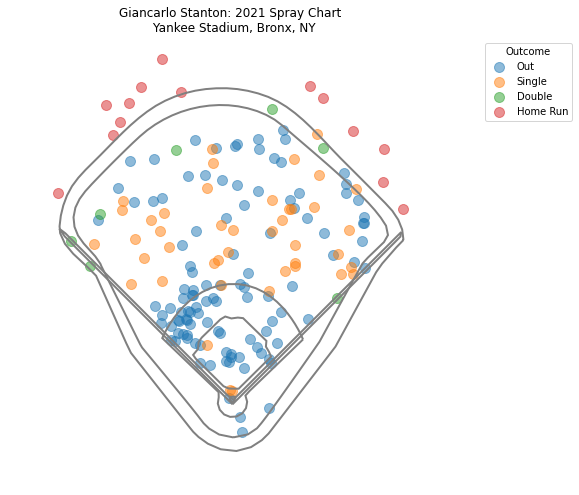

In [8]:
spray_ny = stanton[stanton['home_team'] == 'NYY']
spray_ny = spray_ny.loc[spray_ny['events'] != 'double_play']
spraychart(spray_ny, 'yankees', title = 'Giancarlo Stanton: 2021 Spray Chart \n Yankee Stadium, Bronx, NY');

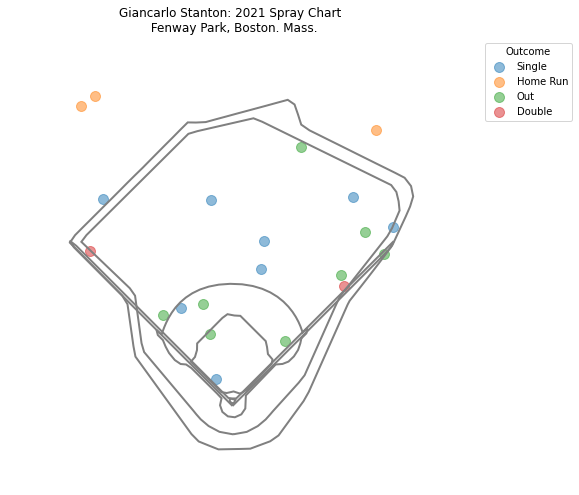

In [9]:
spray_bos = stanton[stanton['home_team'] == 'BOS']
spraychart(spray_bos, 'red_sox', title = 'Giancarlo Stanton: 2021 Spray Chart \n Fenway Park, Boston. Mass.');

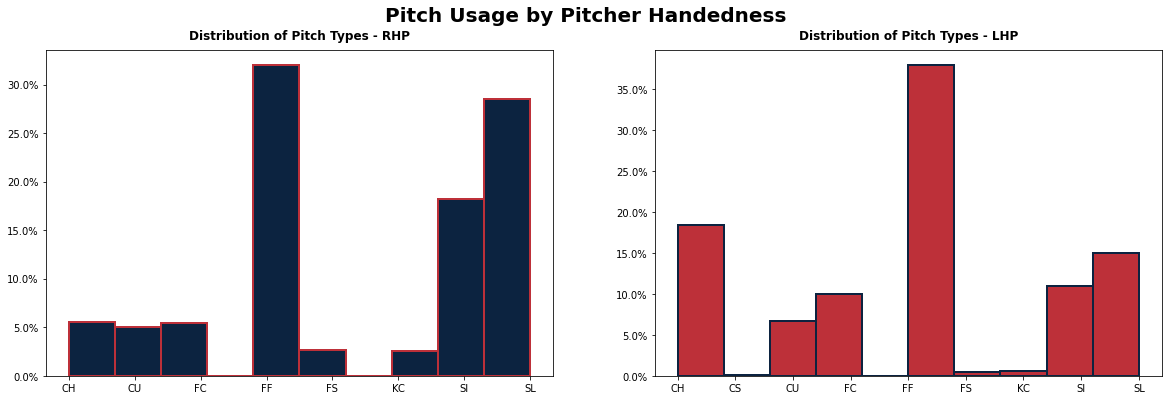

In [10]:
r_stanton.dropna(subset=['pitch_type'], inplace = True)

red = '#BD3039'
blue = '#0C2340'
fig, axs = plt.subplots(1, 2, figsize = (20, 6))
fig.suptitle('Pitch Usage by Pitcher Handedness', fontsize = 20, fontweight = 'bold')

dist_r = r_stanton.pitch_type.sort_values()
axs[0].hist(dist_r, weights = np.ones(len(dist_r)) / len(dist_r), color = blue, edgecolor = red, linewidth = 2)
axs[0].yaxis.set_major_formatter(PercentFormatter(1))
axs[0].set_title('Distribution of Pitch Types - RHP', fontdict = font_title, pad = 15)

dist_l = l_stanton.pitch_type.sort_values()
axs[1].hist(dist_l, weights = np.ones(len(dist_l)) / len(dist_l), color = red, edgecolor = blue, linewidth = 2)
axs[1].yaxis.set_major_formatter(PercentFormatter(1))
axs[1].set_title('Distribution of Pitch Types - LHP', fontdict = font_title, pad = 15);

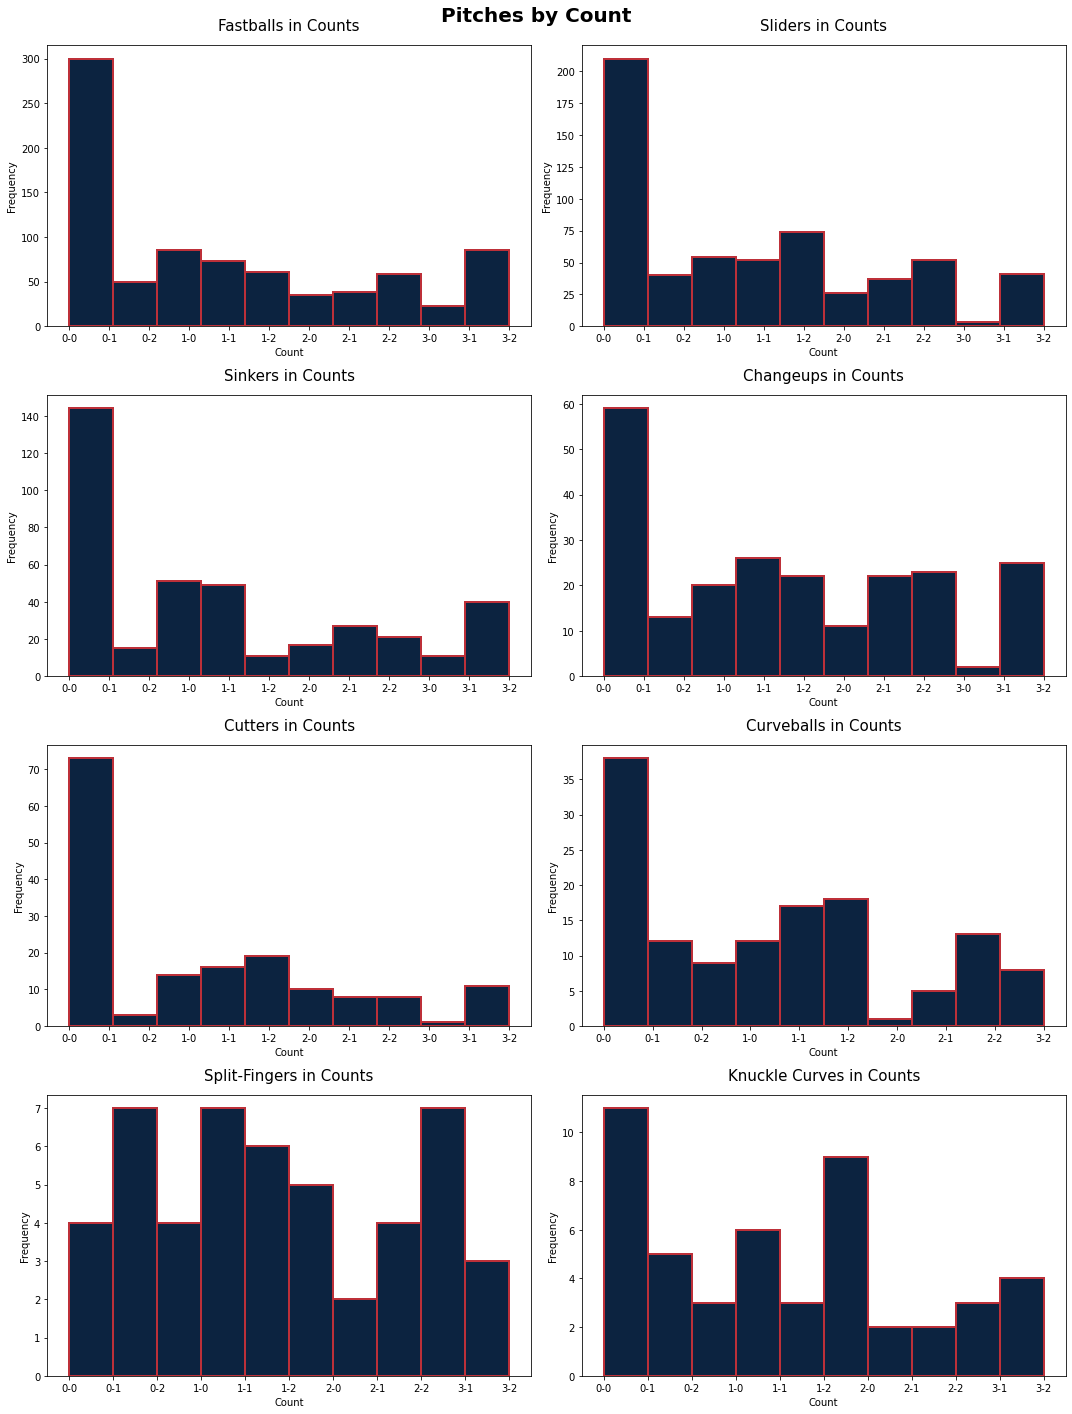

In [11]:
fig, axs = plt.subplots(4, 2, figsize = (15, 20))
fig.suptitle('Pitches by Count', fontsize = 20, fontweight = 'bold')
plt.setp(axs[0:, :], xlabel = 'Count')
plt.setp(axs[:, 0:], ylabel = 'Frequency')

axs[0][0].hist(ff['pitch_count'].sort_values(ascending = True), color = blue, edgecolor = red, linewidth = 2)
axs[0][0].set_title('Fastballs in Counts', fontsize = 15, pad = 15)

axs[0][1].hist(sl['pitch_count'].sort_values(ascending = True), color = blue, edgecolor = red, linewidth = 2)
axs[0][1].set_title('Sliders in Counts', fontsize = 15, pad = 15)

axs[1][0].hist(si['pitch_count'].sort_values(ascending = True), color = blue, edgecolor = red, linewidth = 2)
axs[1][0].set_title('Sinkers in Counts', fontsize = 15, pad = 15)

axs[1][1].hist(ch['pitch_count'].sort_values(ascending = True), color = blue, edgecolor = red, linewidth = 2)
axs[1][1].set_title('Changeups in Counts', fontsize = 15, pad = 15)

axs[2][0].hist(fc['pitch_count'].sort_values(ascending = True), color = blue, edgecolor = red, linewidth = 2)
axs[2][0].set_title('Cutters in Counts', fontsize = 15, pad = 15)

axs[2][1].hist(cu['pitch_count'].sort_values(ascending = True), color = blue, edgecolor = red, linewidth = 2)
axs[2][1].set_title('Curveballs in Counts', fontsize = 15, pad = 15)

axs[3][0].hist(fs['pitch_count'].sort_values(ascending = True), color = blue, edgecolor = red, linewidth = 2)
axs[3][0].set_title('Split-Fingers in Counts', fontsize = 15, pad = 15)

axs[3][1].hist(kc['pitch_count'].sort_values(ascending = True), color = blue, edgecolor = red, linewidth = 2)
axs[3][1].set_title('Knuckle Curves in Counts', fontsize = 15, pad = 15)
plt.tight_layout();

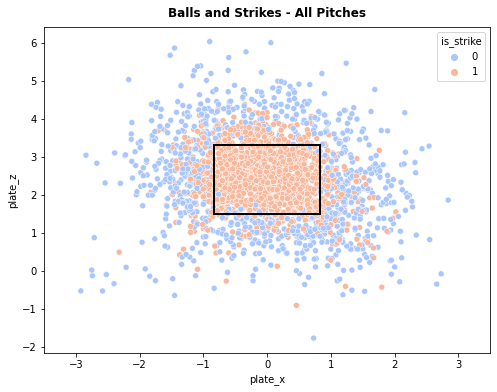

In [12]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = stanton, x = 'plate_x', y = 'plate_z', hue = 'is_strike', palette = 'coolwarm')
left, bottom, width, height = (-.83, 1.5, 1.66, 1.82)
rect = mpatches.Rectangle((left, bottom), width, height,
                          fill = False, color = 'black', linewidth = 2)
plt.gca().add_patch(rect)
plt.xlim(-3.5, 3.5)
plt.title('Balls and Strikes - All Pitches', fontdict = font_title, pad = 15);

### Fastball Heatmaps

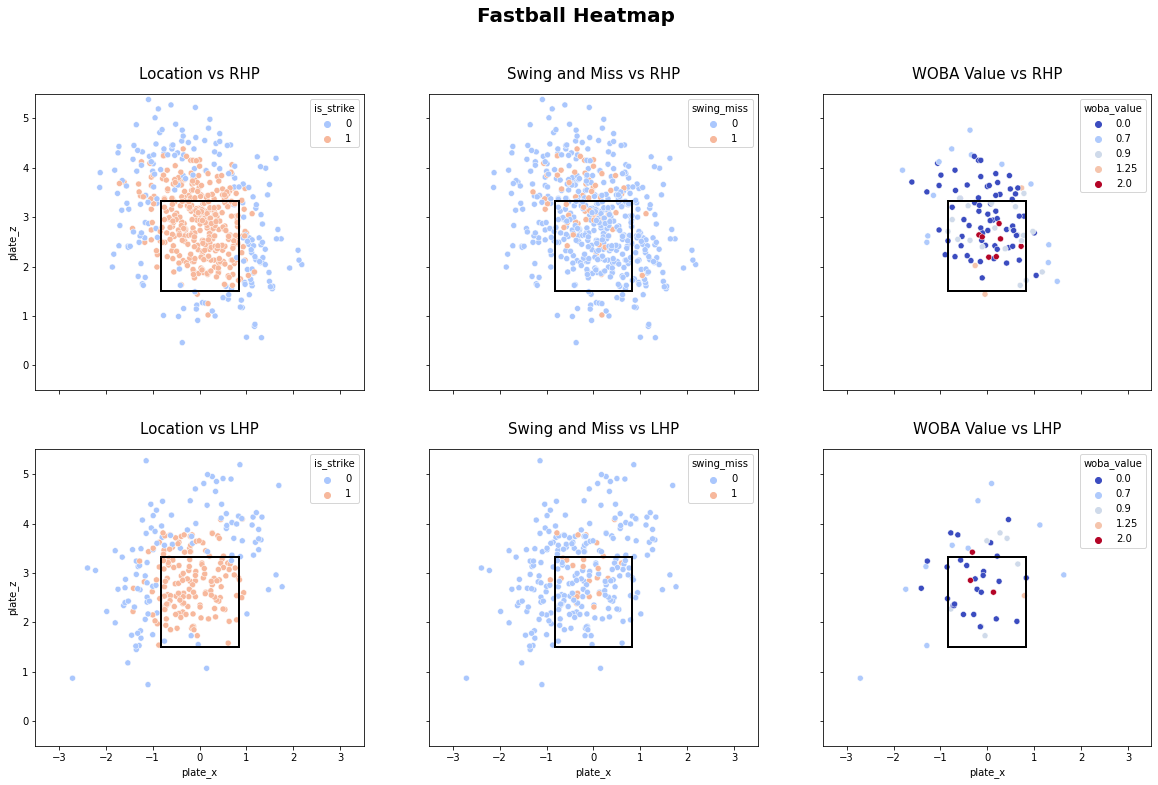

In [13]:
fig, axs = plt.subplots(2, 3, figsize = (20, 12), sharex = True, sharey = True)
fig.suptitle('Fastball Heatmap', fontsize = 20, fontweight = 'bold')
plt.axis(xmin = -3.5, xmax = 3.5)
plt.axis(ymin = -0.5, ymax = 5.5)

sns.scatterplot(ax = axs[0][0],data = r_ff,x = 'plate_x',y = 'plate_z',hue = 'is_strike',palette = 'coolwarm')
axs[0][0].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][0].set_title('Location vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[0][1],data = r_ff,x = 'plate_x',y = 'plate_z',hue = 'swing_miss',palette = 'coolwarm')
axs[0][1].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][1].set_title('Swing and Miss vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[0][2],data = r_ff,x = 'plate_x',y = 'plate_z',hue = 'woba_value',palette = 'coolwarm')
axs[0][2].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][2].set_title('WOBA Value vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][0],data = l_ff,x = 'plate_x',y = 'plate_z',hue = 'is_strike',palette = 'coolwarm')
axs[1][0].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][0].set_title('Location vs LHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][1],data = l_ff,x = 'plate_x',y = 'plate_z',hue = 'swing_miss',palette = 'coolwarm')
axs[1][1].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][1].set_title('Swing and Miss vs LHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][2],data = l_ff,x = 'plate_x',y = 'plate_z',hue = 'woba_value',palette = 'coolwarm')
axs[1][2].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][2].set_title('WOBA Value vs LHP', fontsize = 15, pad = 15);

### Slider Heatmaps

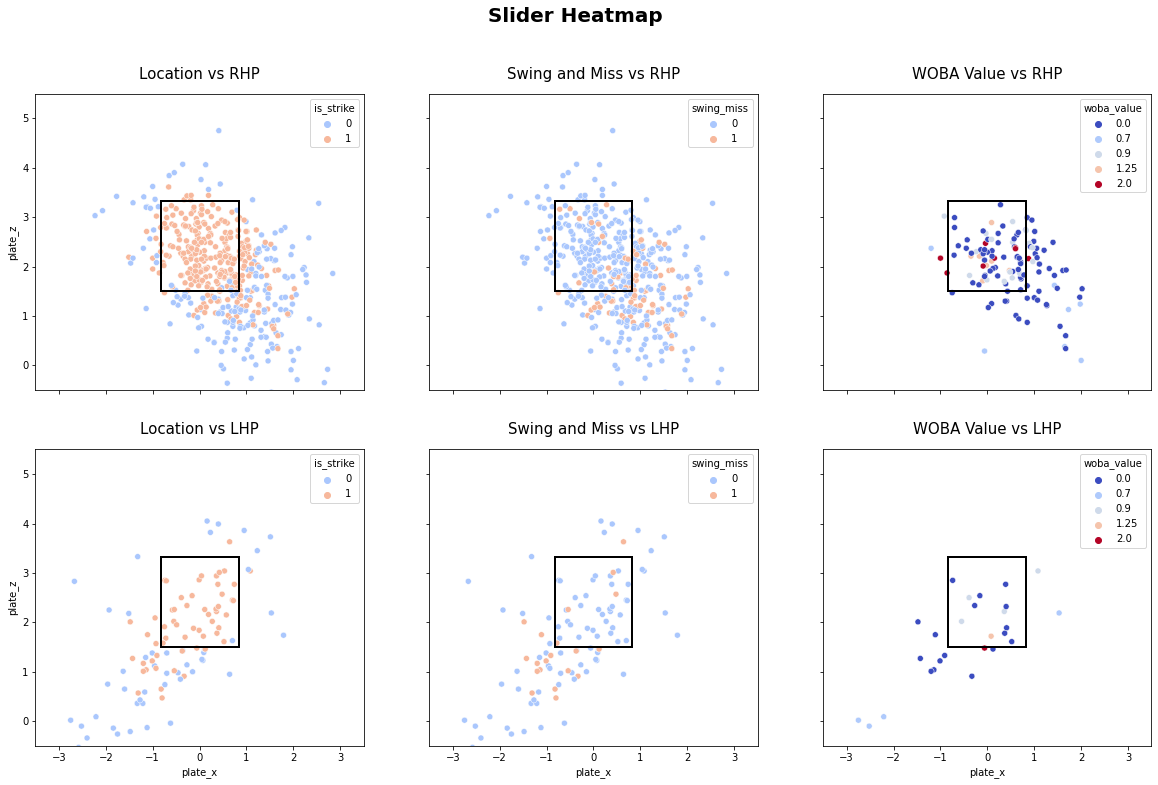

In [14]:
fig, axs = plt.subplots(2, 3, figsize = (20, 12), sharex = True, sharey = True)
fig.suptitle('Slider Heatmap', fontsize = 20, fontweight = 'bold')
plt.axis(xmin = -3.5, xmax = 3.5)
plt.axis(ymin = -0.5, ymax = 5.5)

sns.scatterplot(ax = axs[0][0],data = r_sl,x = 'plate_x',y = 'plate_z',hue = 'is_strike',palette = 'coolwarm')
axs[0][0].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][0].set_title('Location vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[0][1],data = r_sl,x = 'plate_x',y = 'plate_z',hue = 'swing_miss',palette = 'coolwarm')
axs[0][1].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][1].set_title('Swing and Miss vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[0][2],data = r_sl,x = 'plate_x',y = 'plate_z',hue = 'woba_value',palette = 'coolwarm')
axs[0][2].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][2].set_title('WOBA Value vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][0],data = l_sl,x = 'plate_x',y = 'plate_z',hue = 'is_strike',palette = 'coolwarm')
axs[1][0].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][0].set_title('Location vs LHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][1],data = l_sl,x = 'plate_x',y = 'plate_z',hue = 'swing_miss',palette = 'coolwarm')
axs[1][1].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][1].set_title('Swing and Miss vs LHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][2],data = l_sl,x = 'plate_x',y = 'plate_z',hue = 'woba_value',palette = 'coolwarm')
axs[1][2].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][2].set_title('WOBA Value vs LHP', fontsize = 15, pad = 15);

### Sinker Heatmaps

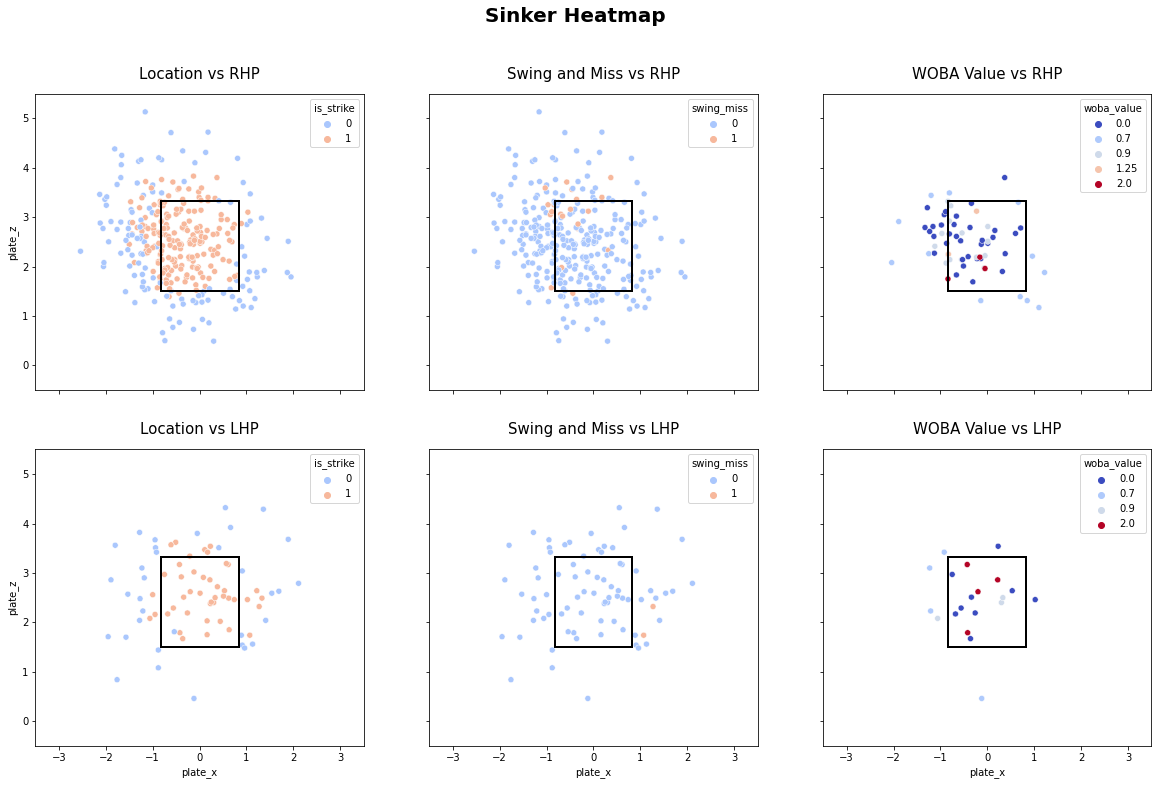

In [15]:
fig, axs = plt.subplots(2, 3, figsize = (20, 12), sharex = True, sharey = True)
fig.suptitle('Sinker Heatmap', fontsize = 20, fontweight = 'bold')
plt.axis(xmin = -3.5, xmax = 3.5)
plt.axis(ymin = -0.5, ymax = 5.5)

sns.scatterplot(ax = axs[0][0],data = r_si,x = 'plate_x',y = 'plate_z',hue = 'is_strike',palette = 'coolwarm')
axs[0][0].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][0].set_title('Location vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[0][1],data = r_si,x = 'plate_x',y = 'plate_z',hue = 'swing_miss',palette = 'coolwarm')
axs[0][1].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][1].set_title('Swing and Miss vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[0][2],data = r_si,x = 'plate_x',y = 'plate_z',hue = 'woba_value',palette = 'coolwarm')
axs[0][2].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][2].set_title('WOBA Value vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][0],data = l_si,x = 'plate_x',y = 'plate_z',hue = 'is_strike',palette = 'coolwarm')
axs[1][0].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][0].set_title('Location vs LHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][1],data = l_si,x = 'plate_x',y = 'plate_z',hue = 'swing_miss',palette = 'coolwarm')
axs[1][1].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][1].set_title('Swing and Miss vs LHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][2],data = l_si,x = 'plate_x',y = 'plate_z',hue = 'woba_value',palette = 'coolwarm')
axs[1][2].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][2].set_title('WOBA Value vs LHP', fontsize = 15, pad = 15);

### Changeup Heatmaps

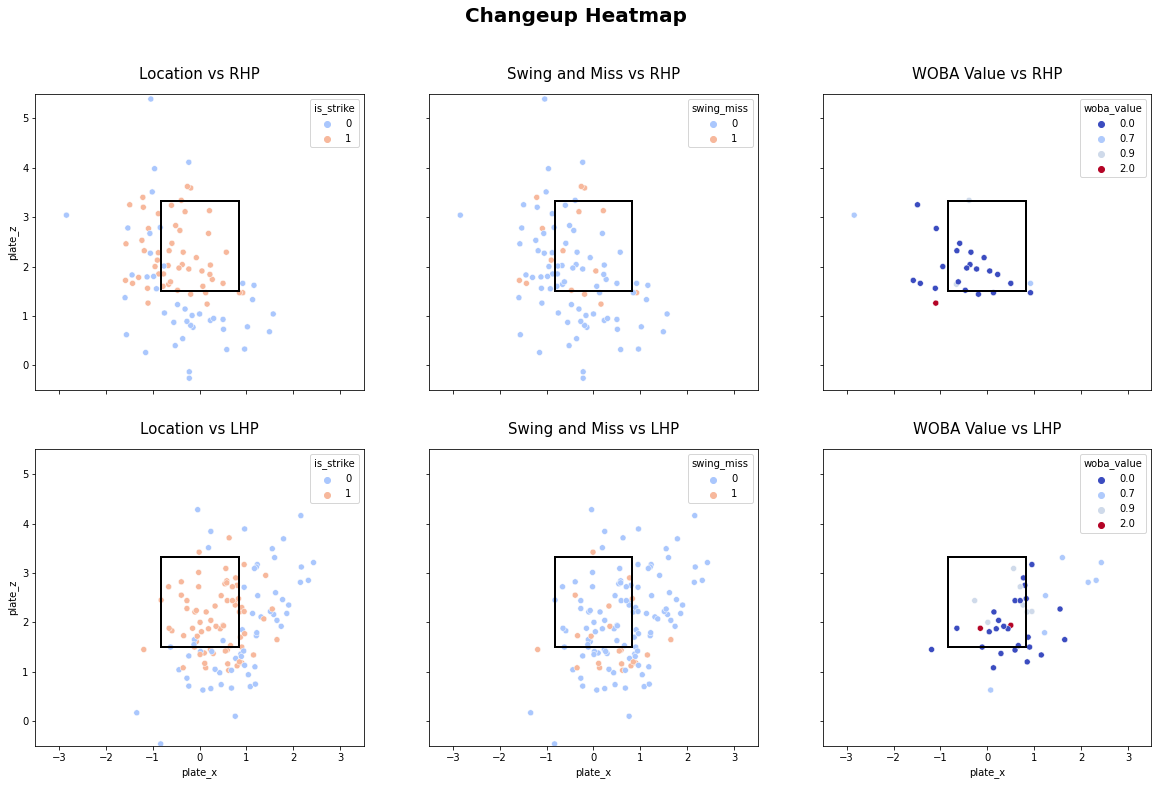

In [16]:
fig, axs = plt.subplots(2, 3, figsize = (20, 12), sharex = True, sharey = True)
fig.suptitle('Changeup Heatmap', fontsize = 20, fontweight = 'bold')
plt.axis(xmin = -3.5, xmax = 3.5)
plt.axis(ymin = -0.5, ymax = 5.5)

sns.scatterplot(ax = axs[0][0],data = r_ch,x = 'plate_x',y = 'plate_z',hue = 'is_strike',palette = 'coolwarm')
axs[0][0].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][0].set_title('Location vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[0][1],data = r_ch,x = 'plate_x',y = 'plate_z',hue = 'swing_miss',palette = 'coolwarm')
axs[0][1].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][1].set_title('Swing and Miss vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[0][2],data = r_ch,x = 'plate_x',y = 'plate_z',hue = 'woba_value',palette = 'coolwarm')
axs[0][2].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][2].set_title('WOBA Value vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][0],data = l_ch,x = 'plate_x',y = 'plate_z',hue = 'is_strike',palette = 'coolwarm')
axs[1][0].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][0].set_title('Location vs LHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][1],data = l_ch,x = 'plate_x',y = 'plate_z',hue = 'swing_miss',palette = 'coolwarm')
axs[1][1].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][1].set_title('Swing and Miss vs LHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][2],data = l_ch,x = 'plate_x',y = 'plate_z',hue = 'woba_value',palette = 'coolwarm')
axs[1][2].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][2].set_title('WOBA Value vs LHP', fontsize = 15, pad = 15);

### Cutter Heatmaps

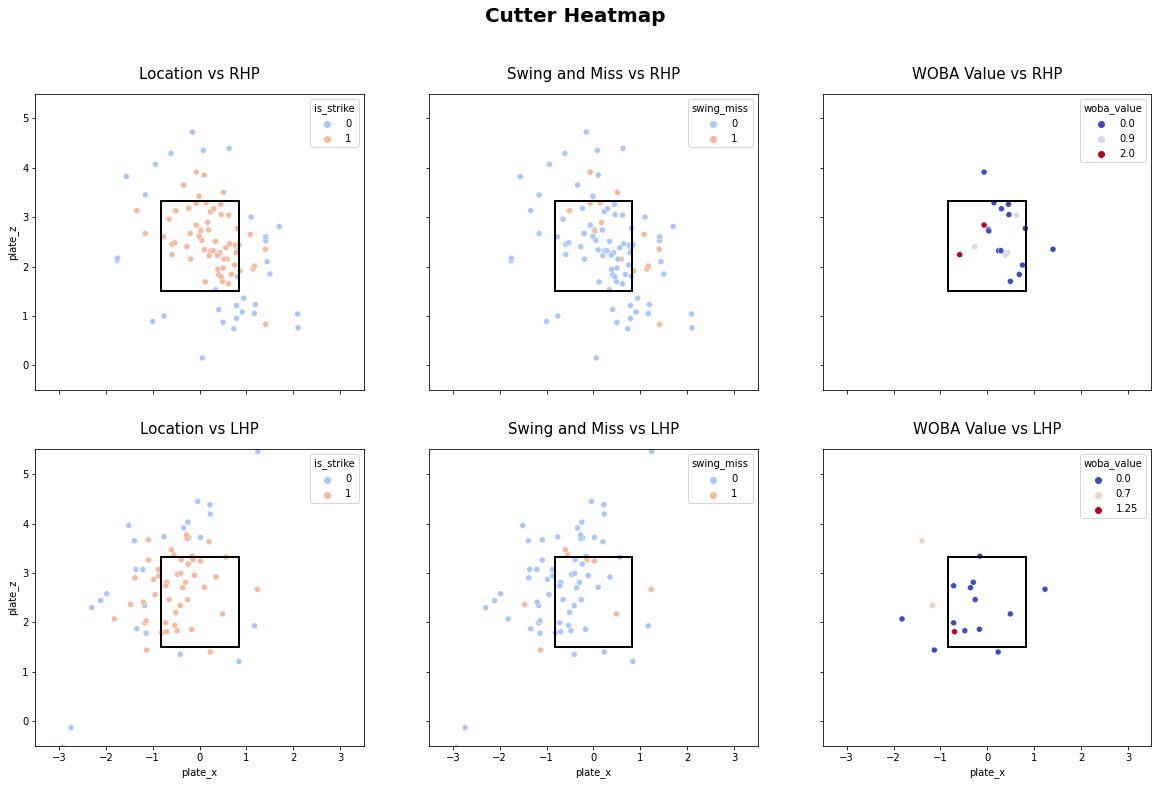

In [17]:
fig, axs = plt.subplots(2, 3, figsize = (20, 12), sharex = True, sharey = True)
fig.suptitle('Cutter Heatmap', fontsize = 20, fontweight = 'bold')
plt.axis(xmin = -3.5, xmax = 3.5)
plt.axis(ymin = -0.5, ymax = 5.5)

sns.scatterplot(ax = axs[0][0],data = r_fc,x = 'plate_x',y = 'plate_z',hue = 'is_strike',palette = 'coolwarm')
axs[0][0].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][0].set_title('Location vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[0][1],data = r_fc,x = 'plate_x',y = 'plate_z',hue = 'swing_miss',palette = 'coolwarm')
axs[0][1].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][1].set_title('Swing and Miss vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[0][2],data = r_fc,x = 'plate_x',y = 'plate_z',hue = 'woba_value',palette = 'coolwarm')
axs[0][2].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][2].set_title('WOBA Value vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][0],data = l_fc,x = 'plate_x',y = 'plate_z',hue = 'is_strike',palette = 'coolwarm')
axs[1][0].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][0].set_title('Location vs LHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][1],data = l_fc,x = 'plate_x',y = 'plate_z',hue = 'swing_miss',palette = 'coolwarm')
axs[1][1].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][1].set_title('Swing and Miss vs LHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][2],data = l_fc,x = 'plate_x',y = 'plate_z',hue = 'woba_value',palette = 'coolwarm')
axs[1][2].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][2].set_title('WOBA Value vs LHP', fontsize = 15, pad = 15);

### Curveball Heatmaps

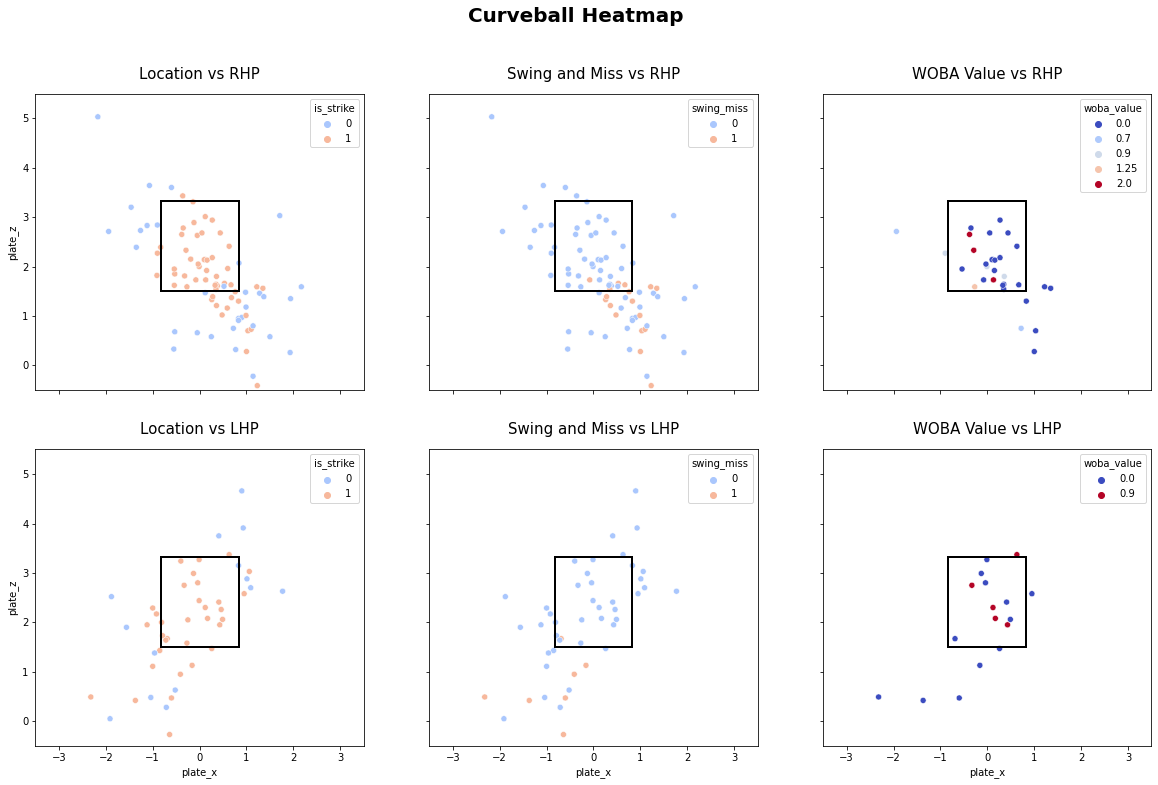

In [18]:
fig, axs = plt.subplots(2, 3, figsize = (20, 12), sharex = True, sharey = True)
fig.suptitle('Curveball Heatmap', fontsize = 20, fontweight = 'bold')
plt.axis(xmin = -3.5, xmax = 3.5)
plt.axis(ymin = -0.5, ymax = 5.5)

sns.scatterplot(ax = axs[0][0],data = r_cu,x = 'plate_x',y = 'plate_z',hue = 'is_strike',palette = 'coolwarm')
axs[0][0].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][0].set_title('Location vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[0][1],data = r_cu,x = 'plate_x',y = 'plate_z',hue = 'swing_miss',palette = 'coolwarm')
axs[0][1].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][1].set_title('Swing and Miss vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[0][2],data = r_cu,x = 'plate_x',y = 'plate_z',hue = 'woba_value',palette = 'coolwarm')
axs[0][2].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][2].set_title('WOBA Value vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][0],data = l_cu,x = 'plate_x',y = 'plate_z',hue = 'is_strike',palette = 'coolwarm')
axs[1][0].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][0].set_title('Location vs LHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][1],data = l_cu,x = 'plate_x',y = 'plate_z',hue = 'swing_miss',palette = 'coolwarm')
axs[1][1].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][1].set_title('Swing and Miss vs LHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][2],data = l_cu,x = 'plate_x',y = 'plate_z',hue = 'woba_value',palette = 'coolwarm')
axs[1][2].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][2].set_title('WOBA Value vs LHP', fontsize = 15, pad = 15);

### Split-Finger Heatmaps

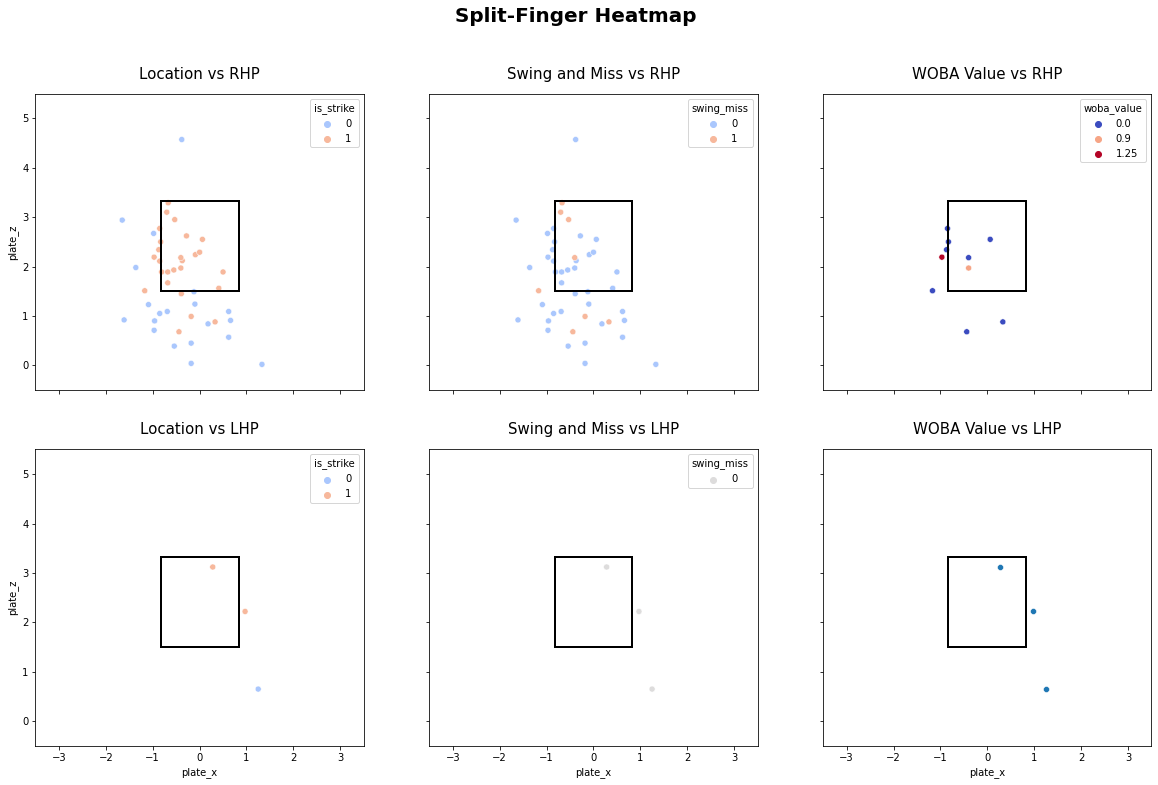

In [19]:
fig, axs = plt.subplots(2, 3, figsize = (20, 12), sharex = True, sharey = True)
fig.suptitle('Split-Finger Heatmap', fontsize = 20, fontweight = 'bold')
plt.axis(xmin = -3.5, xmax = 3.5)
plt.axis(ymin = -0.5, ymax = 5.5)

sns.scatterplot(ax = axs[0][0],data = r_fs,x = 'plate_x',y = 'plate_z',hue = 'is_strike',palette = 'coolwarm')
axs[0][0].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][0].set_title('Location vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[0][1],data = r_fs,x = 'plate_x',y = 'plate_z',hue = 'swing_miss',palette = 'coolwarm')
axs[0][1].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][1].set_title('Swing and Miss vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[0][2],data = r_fs,x = 'plate_x',y = 'plate_z',hue = 'woba_value',palette = 'coolwarm')
axs[0][2].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][2].set_title('WOBA Value vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][0],data = l_fs,x = 'plate_x',y = 'plate_z',hue = 'is_strike',palette = 'coolwarm')
axs[1][0].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][0].set_title('Location vs LHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][1],data = l_fs,x = 'plate_x',y = 'plate_z',hue = 'swing_miss',palette = 'coolwarm')
axs[1][1].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][1].set_title('Swing and Miss vs LHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][2],data = l_fs,x = 'plate_x',y = 'plate_z',hue = 'woba_value',palette = 'coolwarm')
axs[1][2].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][2].set_title('WOBA Value vs LHP', fontsize = 15, pad = 15);

### Knuckle Curve Heatmaps

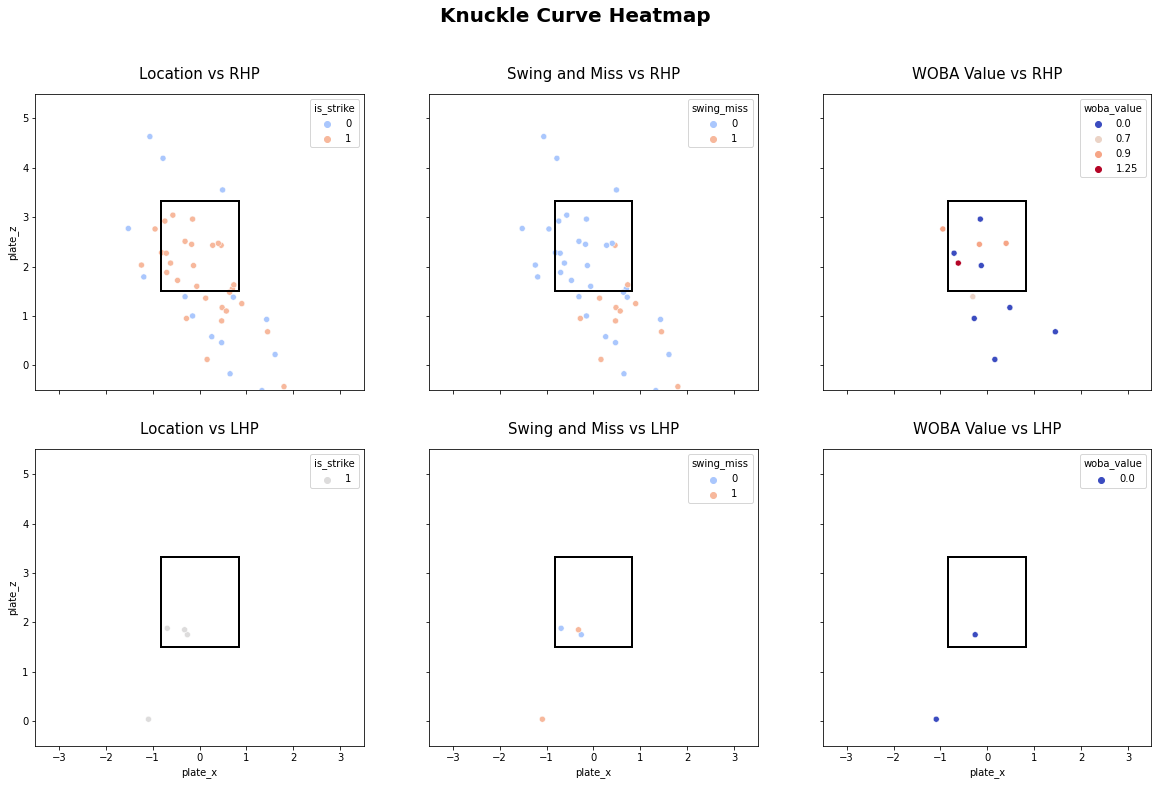

In [20]:
fig, axs = plt.subplots(2, 3, figsize = (20, 12), sharex = True, sharey = True)
fig.suptitle('Knuckle Curve Heatmap', fontsize = 20, fontweight = 'bold')
plt.axis(xmin = -3.5, xmax = 3.5)
plt.axis(ymin = -0.5, ymax = 5.5)

sns.scatterplot(ax = axs[0][0],data = r_kc,x = 'plate_x',y = 'plate_z',hue = 'is_strike',palette = 'coolwarm')
axs[0][0].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][0].set_title('Location vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[0][1],data = r_kc,x = 'plate_x',y = 'plate_z',hue = 'swing_miss',palette = 'coolwarm')
axs[0][1].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][1].set_title('Swing and Miss vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[0][2],data = r_kc,x = 'plate_x',y = 'plate_z',hue = 'woba_value',palette = 'coolwarm')
axs[0][2].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][2].set_title('WOBA Value vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][0],data = l_kc,x = 'plate_x',y = 'plate_z',hue = 'is_strike',palette = 'coolwarm')
axs[1][0].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][0].set_title('Location vs LHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][1],data = l_kc,x = 'plate_x',y = 'plate_z',hue = 'swing_miss',palette = 'coolwarm')
axs[1][1].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][1].set_title('Swing and Miss vs LHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][2],data = l_kc,x = 'plate_x',y = 'plate_z',hue = 'woba_value',palette = 'coolwarm')
axs[1][2].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][2].set_title('WOBA Value vs LHP', fontsize = 15, pad = 15);

### Slow Curve Heatmaps

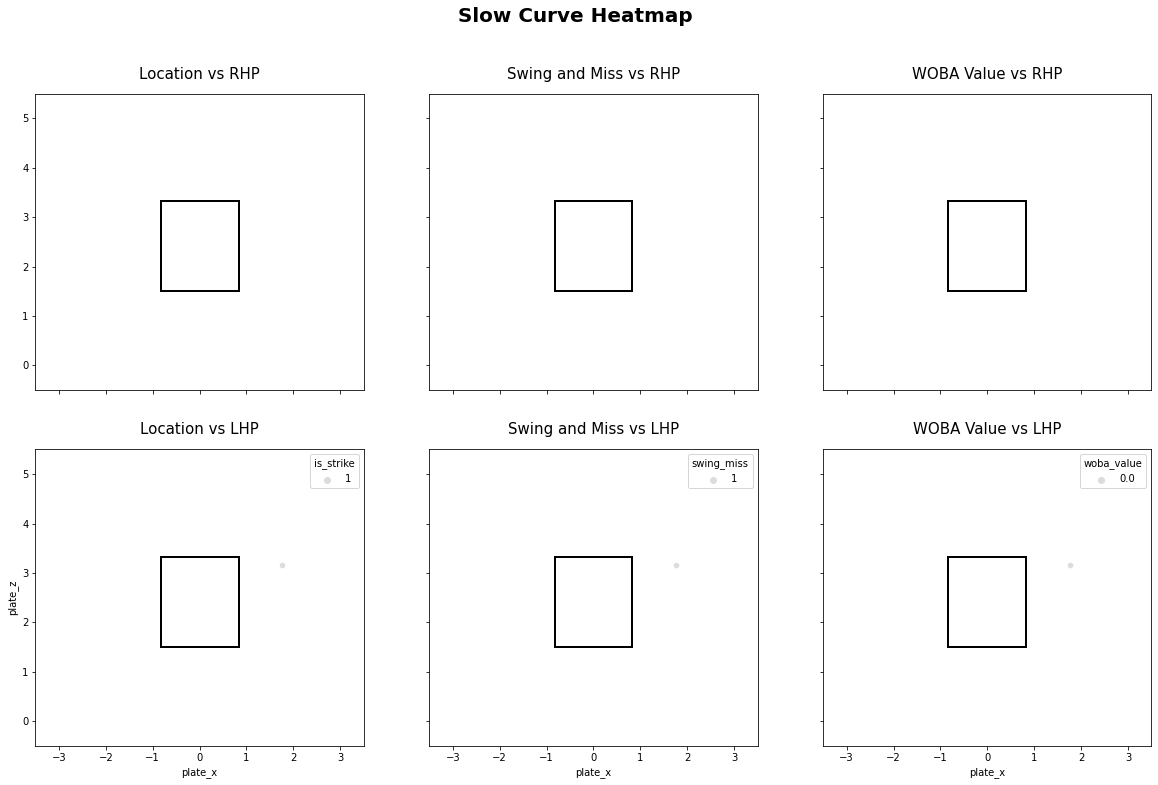

In [21]:
fig, axs = plt.subplots(2, 3, figsize = (20, 12), sharex = True, sharey = True)
fig.suptitle('Slow Curve Heatmap', fontsize = 20, fontweight = 'bold')
plt.axis(xmin = -3.5, xmax = 3.5)
plt.axis(ymin = -0.5, ymax = 5.5)

sns.scatterplot(ax = axs[0][0],data = r_cs,x = 'plate_x',y = 'plate_z',hue = 'is_strike',palette = 'coolwarm')
axs[0][0].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][0].set_title('Location vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[0][1],data = r_cs,x = 'plate_x',y = 'plate_z',hue = 'swing_miss',palette = 'coolwarm')
axs[0][1].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][1].set_title('Swing and Miss vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[0][2],data = r_cs,x = 'plate_x',y = 'plate_z',hue = 'woba_value',palette = 'coolwarm')
axs[0][2].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][2].set_title('WOBA Value vs RHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][0],data = l_cs,x = 'plate_x',y = 'plate_z',hue = 'is_strike',palette = 'coolwarm')
axs[1][0].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][0].set_title('Location vs LHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][1],data = l_cs,x = 'plate_x',y = 'plate_z',hue = 'swing_miss',palette = 'coolwarm')
axs[1][1].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][1].set_title('Swing and Miss vs LHP', fontsize = 15, pad = 15)

sns.scatterplot(ax = axs[1][2],data = l_cs,x = 'plate_x',y = 'plate_z',hue = 'woba_value',palette = 'coolwarm')
axs[1][2].add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][2].set_title('WOBA Value vs LHP', fontsize = 15, pad = 15);